In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import json
import random
import sys


def get_data(date_end, historical_days, wallet_stocks):
    with open('stock_data/stocks_prices.json', 'r') as file:
        dict_stocks = json.load(file)
    with open('stock_data/dates.json', 'r') as file:
        dates = json.load(file)

    # dates
    date_data = []
    end = dates.index(date_end)
    start = end - historical_days
    for i in range(start, end+1):
        date_data.append(dates[i])

    price_data = np.zeros((historical_days+1, len(wallet_stocks)))
    column = 0
    for stock in wallet_stocks:
        price = []
        for data in date_data:
            try:
                price.append(dict_stocks[stock][data])
            except KeyError:
                price.append(0)
        price_data[:, column] = np.array(price)
        column += 1

    # print(date_data[-1], date_data[0])
    return price_data, np.array(date_data)


def get_returns(price_data):
    return_data = np.zeros((price_data.shape[0]-1, price_data.shape[1]))
    for column in range(return_data.shape[1]):
        for row in range(return_data.shape[0]):
            return_data[row, column] = (price_data[row+1, column] /
                                        price_data[row, column]  - 1)
    return return_data


def historical_returns_wallet(return_data, stocks_portfolio, tamanho_posicoes):
    pl_total = tamanho_posicoes * len(stocks_portfolio)
    return_wallet = []
    for i in range(return_data.shape[0]):    
        daily_returns = tamanho_posicoes * return_data[i, :]
        return_wallet.append(np.sum(daily_returns) / pl_total)

    return np.array(return_wallet)


def cotizacao_carteira(returns_array):
    cota = [1]
    for i in range (len(returns_array)):
        cota.append(cota[i] * (returns_array[i] + 1))
    return np.array(cota)


def get_volatility_stock(stocks, day_start, past_days):
    stock_data, date = get_data(day_start, past_days, stocks)
    daily_return = get_returns(stock_data)
    return np.std(daily_return), daily_return


def cota_to_return(cotizacao):
    retorno_cota = []
    for i in range(1, len(cotizacao)):
        retorno_cota.append(cotizacao[i] / cotizacao[i-1] -1)
    return  np.array(retorno_cota)


def wallet_return(return_data, stocks_portfolio, positions, total_capital):
    # return shape = 126, 15 // position shape 15
    return_wallet = []
    for i in range(return_data.shape[0]):    
        daily_returns = positions * return_data[i, :]
        return_wallet.append(np.sum(daily_returns) / total_capital)
        positions = positions + daily_returns
        total_capital = np.sum(positions)
    return np.array(return_wallet)

# stock list treatment
historico_dias = 1000
df = pd.read_excel('ibovespa_composition.xlsx')
ibovespa_stocks = np.array(df['CODIGOS'])
price_hist, date_hist = get_data('2024-01-31', historico_dias, ibovespa_stocks)
stocks_delete = np.where(price_hist[0, :] == 0)
ibovespa_stocks = np.delete(ibovespa_stocks, stocks_delete[0], axis=0)
qtd_stocks = len(ibovespa_stocks)


Rentabilidade das Carteiras
Média: 12.81% 
Mediana: 11.51% 
Desvio padrão: 18.57% 
Primeiro quartil (Q1): -0.65% 
Terceiro quartil (Q3): 24.83% 
Carteiras no positivo: 73.40% 
 
Volatilidade das Carteiras
Média: 30.47% 
Mediana: 30.37% 


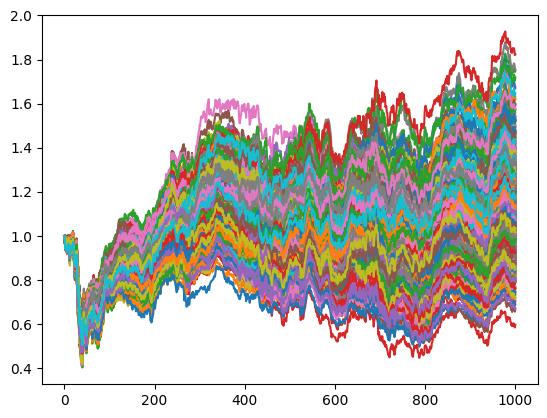

In [2]:
perc_alocacao = 1.0
tamanho_portfolio = 15
iteracoes = 1000

cota_iteracoes = []
vol_cotas = []
for interacao in range(iteracoes):

    # portfolio selection
    choosen_stock = random.sample(range(0, qtd_stocks), tamanho_portfolio)        
    portfolio = []
    for item in choosen_stock:
        portfolio.append(ibovespa_stocks[item])

    # collect price data
    price_hist, date_hist = get_data('2024-01-31', historico_dias, portfolio)
    returns = get_returns(price_hist)

    if np.where(price_hist[0, :] == 0)[0].size != 0:
        print("Prices error")
        sys.exit()

    retorno_cota = historical_returns_wallet(returns, portfolio, 1000)
    retorno_cota = perc_alocacao * retorno_cota
    cota_carteira = cotizacao_carteira(retorno_cota)

    # vol_cotas.append(np.std(retorno_cota) * np.sqrt(252))
    cota_iteracoes.append(cota_carteira)

cotas = np.array(cota_iteracoes)
cotas = np.transpose(cotas)

rent_cotas = []
vol_cotas = []
for i in range(cotas.shape[1]):
    rent_cotas.append(cotas[-1, i] / cotas[0, i] - 1)
    retorno = cota_to_return(cotas[:, i])
    vol_cotas.append(np.std(retorno) * np.sqrt(252))

rent_cotas = np.array(rent_cotas)
vol_cotas = np.array(vol_cotas)

plt.plot(cotas);

array_registros = rent_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)


print("Rentabilidade das Carteiras")
print("Média: %.2f%% " % (media * 100))
print("Mediana: %.2f%% " % (mediana * 100))
print("Desvio padrão: %.2f%% " % (desvio_padrao * 100))
print("Primeiro quartil (Q1): %.2f%% " % (q1 * 100))
print("Terceiro quartil (Q3): %.2f%% " % (q3 * 100))
print("Carteiras no positivo: %.2f%% " % (np.sum(array_registros > 0) / len(array_registros) * 100))
print(" ")

array_registros = vol_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)


print("Volatilidade das Carteiras")
print("Média: %.2f%% " % (media * 100))
print("Mediana: %.2f%% " % (mediana * 100))


Retorno ibovespa: 7.59%
Volatilidade ibovespa: 28.24%


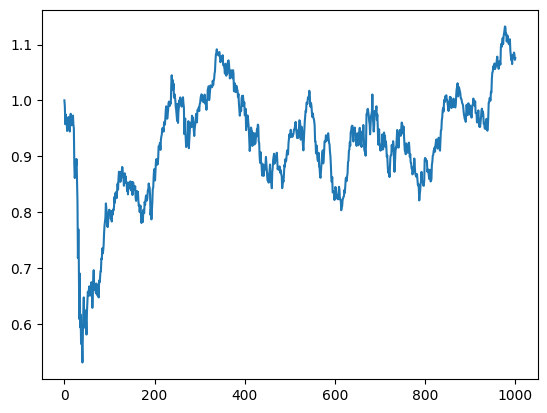

In [3]:
# portfolio bova11
vol_ibov, return_ibov = get_volatility_stock(['BOVA11'], '2024-01-31', historico_dias)
return_ibov = np.squeeze(return_ibov)
cota_ibov = cotizacao_carteira(return_ibov)

plt.plot(cota_ibov);

print("Retorno ibovespa: %.2f%%" % ((cota_ibov[-1] / cota_ibov[0] - 1) * 100))
print("Volatilidade ibovespa: %.2f%%" % ((np.std(return_ibov) * np.sqrt(252)) * 100))

Rentabilidade das Carteiras
Média: -9.93% 
Mediana: -10.33% 
Desvio padrão: 9.02% 
Primeiro quartil (Q1): -16.05% 
Terceiro quartil (Q3): -4.07% 
Carteiras no positivo: 12.60% 
 
Volatilidade das Carteiras
Média: 9.15% 
Mediana: 9.12% 


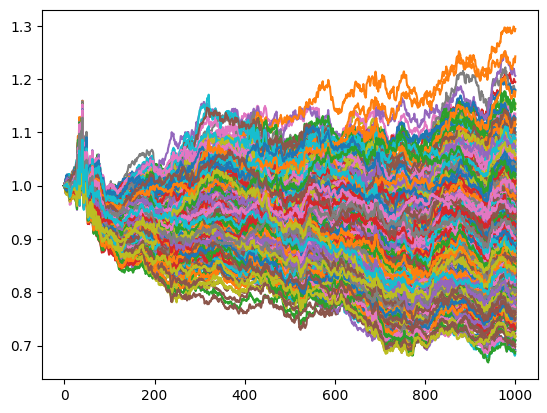

In [4]:
tamanho_portfolio = 15
cota_iteracoes = []
vol_cotas = []
for interacao in range(iteracoes):

    # portfolio selection
    choosen_stock = random.sample(range(0, qtd_stocks), tamanho_portfolio)        
    portfolio = []
    for item in choosen_stock:
        portfolio.append(ibovespa_stocks[item])

    # collect price data
    price_hist, date_hist = get_data('2024-01-31', historico_dias, portfolio)
    returns = get_returns(price_hist)

    if np.where(price_hist[0, :] == 0)[0].size != 0:
        print("Prices error")
        sys.exit()

    retorno_cota = historical_returns_wallet(returns, portfolio, 1000)
    cota_carteira = cotizacao_carteira(retorno_cota)
    vol_ibov, return_ibov = get_volatility_stock(['BOVA11'], '2024-01-31', historico_dias)
    return_ibov = np.squeeze(return_ibov * -1)
    cota_ibov = cotizacao_carteira(return_ibov)

    cota_x = (cota_carteira  + cota_ibov) / 2
    retorno_x = cota_to_return(cota_x)

    vol_cotas.append(np.std(retorno_x) * np.sqrt(252)) ##
    cota_iteracoes.append(cota_x)

cotas = np.array(cota_iteracoes)
cotas = np.transpose(cotas)

rent_cotas = []
for i in range(cotas.shape[1]):
    rent_cotas.append(cotas[-1, i] / cotas[0, i] - 1)

rent_cotas = np.array(rent_cotas)
vol_cotas = np.array(vol_cotas)

plt.plot(cotas);

array_registros = rent_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)

print("Rentabilidade das Carteiras")
print("Média: %.2f%% " % (media * 100))
print("Mediana: %.2f%% " % (mediana * 100))
print("Desvio padrão: %.2f%% " % (desvio_padrao * 100))
print("Primeiro quartil (Q1): %.2f%% " % (q1 * 100))
print("Terceiro quartil (Q3): %.2f%% " % (q3 * 100))
print("Carteiras no positivo: %.2f%% " % (np.sum(array_registros > 0) / len(array_registros) * 100))
print(" ")

array_registros = vol_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)

print("Volatilidade das Carteiras")
print("Média: %.2f%% " % (media * 100))
print("Mediana: %.2f%% " % (mediana * 100))

Rentabilidade das Carteiras
Média: 10.38% 
Mediana: 8.57% 
Desvio padrão: 17.71% 
Primeiro quartil (Q1): -2.37% 
Terceiro quartil (Q3): 22.06% 
Carteiras no positivo: 69.50% 
 
Volatilidade das Cotas
Média: 28.40% 
Mediana: 28.31% 


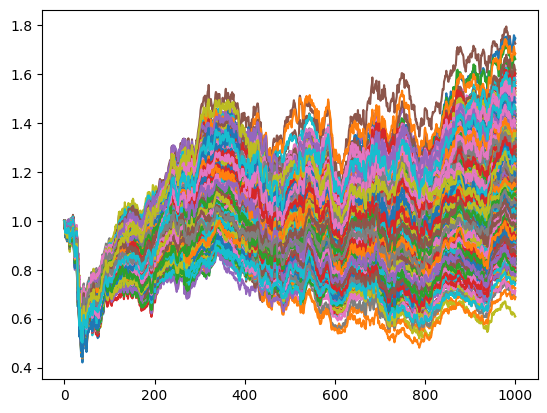

In [5]:
perc_alocacao = 1.0
tamanho_portfolio = 15
positions = np.full((1, 15), 100000)
capital = np.sum(positions)

cota_iteracoes = []
vol_cotas = []
for interacao in range(iteracoes):

    # portfolio selection
    choosen_stock = random.sample(range(0, qtd_stocks), tamanho_portfolio)        
    portfolio = []
    for item in choosen_stock:
        portfolio.append(ibovespa_stocks[item])

    # collect price data
    price_hist, date_hist = get_data('2024-01-31', historico_dias, portfolio)
    returns = get_returns(price_hist)

    if np.where(price_hist[0, :] == 0)[0].size != 0:
        print("Prices error")
        sys.exit()

    retorno_cota = wallet_return(returns, portfolio, positions, capital)
    # retorno_cota = historical_returns_wallet(returns, portfolio, 1000)
    retorno_cota = perc_alocacao * retorno_cota
    cota_carteira = cotizacao_carteira(retorno_cota)
    cota_iteracoes.append(cota_carteira)

cotas = np.array(cota_iteracoes)
cotas = np.transpose(cotas)

rent_cotas = []
vol_cotas = []
for i in range(cotas.shape[1]):
    rent_cotas.append(cotas[-1, i] / cotas[0, i] - 1)
    retorno = cota_to_return(cotas[:, i])
    vol_cotas.append(np.std(retorno) * np.sqrt(252))

rent_cotas = np.array(rent_cotas)
vol_cotas = np.array(vol_cotas)

plt.plot(cotas);

array_registros = rent_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)

print("Rentabilidade das Carteiras")
print("Média: %.2f%% " % (media * 100))
print("Mediana: %.2f%% " % (mediana * 100))
print("Desvio padrão: %.2f%% " % (desvio_padrao * 100))
print("Primeiro quartil (Q1): %.2f%% " % (q1 * 100))
print("Terceiro quartil (Q3): %.2f%% " % (q3 * 100))
print("Carteiras no positivo: %.2f%% " % (np.sum(array_registros > 0) / len(array_registros) * 100))
print(" ")

array_registros = vol_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)

print("Volatilidade das Cotas")
print("Média: %.2f%% " % (media * 100))
print("Mediana: %.2f%% " % (mediana * 100))

Rentabilidade das Carteiras
Média: -10.32% 
Mediana: -11.08% 
Desvio padrão: 8.85% 
Primeiro quartil (Q1): -16.78% 
Terceiro quartil (Q3): -4.53% 
Carteiras no positivo: 12.80% 
 
Volatilidade das Carteiras
Média: 9.07% 
Mediana: 9.06% 


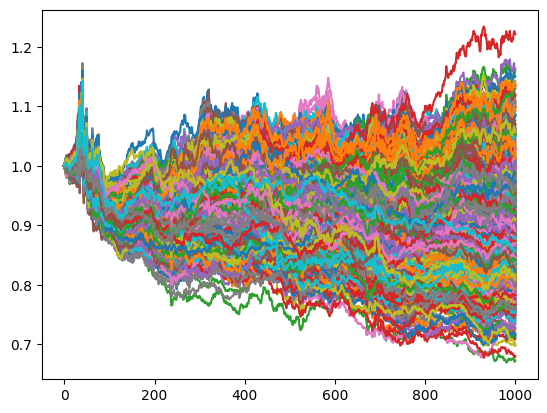

In [6]:
cota_iteracoes = []
vol_cotas = []

perc_alocacao = 1.0
tamanho_portfolio = 15
positions = np.full((1, 15), 100000)
capital = np.sum(positions)

for interacao in range(iteracoes):

    # portfolio selection
    choosen_stock = random.sample(range(0, qtd_stocks), tamanho_portfolio)        
    portfolio = []
    for item in choosen_stock:
        portfolio.append(ibovespa_stocks[item])

    # collect price data
    price_hist, date_hist = get_data('2024-01-31', historico_dias, portfolio)
    returns = get_returns(price_hist)

    if np.where(price_hist[0, :] == 0)[0].size != 0:
        print("Prices error")
        sys.exit()

    # retorno_cota = historical_returns_wallet(returns, portfolio, 1000)
    retorno_cota = wallet_return(returns, portfolio, positions, capital)
    cota_carteira = cotizacao_carteira(retorno_cota)
    vol_ibov, return_ibov = get_volatility_stock(['BOVA11'], '2024-01-31', historico_dias)
    return_ibov = np.squeeze(return_ibov * -1)
    cota_ibov = cotizacao_carteira(return_ibov)

    cota_x = (cota_carteira  + cota_ibov) / 2
    retorno_x = cota_to_return(cota_x)

    vol_cotas.append(np.std(retorno_x) * np.sqrt(252)) ##
    cota_iteracoes.append(cota_x)

cotas = np.array(cota_iteracoes)
cotas = np.transpose(cotas)

rent_cotas = []
for i in range(cotas.shape[1]):
    rent_cotas.append(cotas[-1, i] / cotas[0, i] - 1)

rent_cotas = np.array(rent_cotas)
vol_cotas = np.array(vol_cotas)

plt.plot(cotas);

array_registros = rent_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)

array_registros = rent_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)

print("Rentabilidade das Carteiras")
print("Média: %.2f%% " % (media * 100))
print("Mediana: %.2f%% " % (mediana * 100))
print("Desvio padrão: %.2f%% " % (desvio_padrao * 100))
print("Primeiro quartil (Q1): %.2f%% " % (q1 * 100))
print("Terceiro quartil (Q3): %.2f%% " % (q3 * 100))
print("Carteiras no positivo: %.2f%% " % (np.sum(array_registros > 0) / len(array_registros) * 100))
print(" ")

array_registros = vol_cotas

indices = np.arange(len(array_registros))
media = np.mean(array_registros)  # Média
mediana = np.median(array_registros)  # Mediana
desvio_padrao = np.std(array_registros)  # Desvio padrão
q1 = np.percentile(array_registros, 25)  # Primeiro quartil (25%)
q3 = np.percentile(array_registros, 75)  # Terceiro quartil (75%)

print("Volatilidade das Carteiras")
print("Média: %.2f%% " % (media * 100))
print("Mediana: %.2f%% " % (mediana * 100))